In [1]:
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

%matplotlib inline

train_start = '2000-01-01'
train_stop = '2023-01-01'

### Store all asset price series in a single dataframe

In [2]:
asset_files = ['TLT', 'GLD', 'SLV',
               'XLB', 'XLE', 'XLF',
               'XLI', 'XLK', 'XLI',
               'XLK', 'XLP', 'XLU',
               'XLV', 'XLY']

assets_close_prices = pd.DataFrame()

for file in asset_files:
    filename = file + '.csv'
    temp = pd.read_csv(filename)
    temp.set_index(keys='date', drop=True, inplace=True)
    
    log_rets = temp['close'].apply(np.log).diff(1) # convert price series into log returns series
    assets_close_prices[file] = log_rets
    
assets_close_prices = assets_close_prices[assets_close_prices.index > train_start]
assets_close_prices = assets_close_prices[assets_close_prices.index < train_stop]
assets_close_prices

,TLT,GLD,SLV,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
date,,,,,,,,,,,,
2002-07-30,NaN,NaN,NaN,-0.038246,-0.015657,0.002205,0.011602,0.015396,-0.010031,0.078224,0.007298,-0.003695
2002-07-31,0.012313,NaN,NaN,0.001947,0.017431,0.015301,-0.001776,-0.005571,0.022313,0.003876,0.028298,-0.004948
2002-08-01,0.005679,NaN,NaN,-0.006343,-0.060735,-0.025040,-0.022473,-0.044992,-0.009434,-0.014613,-0.028298,-0.031069
2002-08-02,0.010189,NaN,NaN,-0.043007,-0.011364,-0.025683,-0.037041,-0.021411,-0.001898,-0.019822,-0.008069,-0.045363
2002-08-05,0.004403,NaN,NaN,-0.034836,-0.037850,-0.040043,-0.033576,-0.044248,-0.013866,-0.017673,-0.043768,-0.023477
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-03,-0.026601,-0.015503,-0.015461,-0.013108,0.030520,0.012217,-0.008256,0.009445,-0.000130,-0.009968,-0.010345,0.028308
2022-01-04,-0.004167,0.007340,0.006588,0.012225,0.034018,0.025969,0.019907,-0.010654,0.006722,-0.003109,-0.013283,-0.006105
2022-01-05,-0.005443,-0.003012,-0.015123,-0.000110,-0.000169,-0.011653,-0.009574,-0.031232,-0.000902,-0.000566,-0.007148,-0.027352


### Create a distance matrix

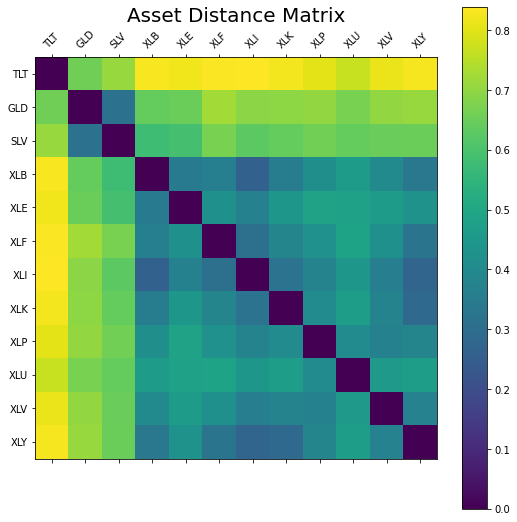

In [12]:
corr_mat = assets_close_prices.corr(method='pearson') # pearson correlation matrix
dist_mat = (0.5 * (1 - corr_mat)) ** 0.5 # angular distance matrix (Using this for a long only portfolio. We would use absolute or squared angular distance for a long-short portfolio)

# Plot distance matrix
f = plt.figure(figsize=(9, 9))
plt.matshow(dist_mat, fignum=f.number)
plt.xticks(range(dist_mat.select_dtypes(['number']).shape[1]), dist_mat.select_dtypes(['number']).columns, fontsize=10, rotation=45)
plt.yticks(range(dist_mat.select_dtypes(['number']).shape[1]), dist_mat.select_dtypes(['number']).columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.title('Asset Distance Matrix', fontsize=20);

### Quasi-diagonalization:
#### Reorganizes the rows and columns of the covariance matrix, so that the largest values lie along the diagonal

C:\Users\14843\AppData\Local\Temp/ipykernel_9980/107305649.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = linkage(dist_mat, 'ward')


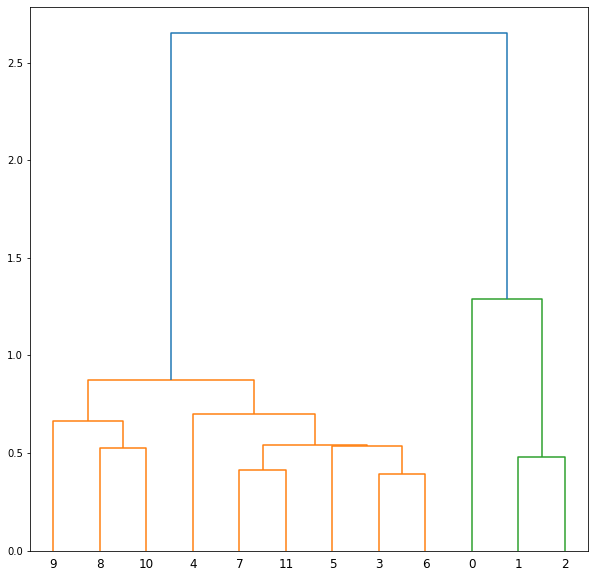

In [13]:
link = linkage(dist_mat, 'ward')
Z = pd.DataFrame(link)

fig = plt.figure(figsize=(10, 10))
dn = dendrogram(Z)
plt.show()

In [14]:
def get_quasi_diag(link):
    
    # sort clustered items by distance
    
    link = link.astype(int)
    
    # get the first and the second item of the last tuple
    sort_ix = pd.Series([link[-1,0], link[-1,1]]) 
    
    # the total num of items is the third item of the last list
    num_items = link[-1, 3]
    
    # if the max of sort_ix is bigger than or equal to the max_items
    while sort_ix.max() >= num_items:
        # assign sort_ix index with 24 x 24
        sort_ix.index = range(0, sort_ix.shape[0]*2, 2) # odd numers as index
        
        df0 = sort_ix[sort_ix >= num_items] # find clusters
        
        # df0 contain even index and cluster index
        i = df0.index
        j = df0.values - num_items # 
        
        sort_ix[i] = link[j,0] # item 1
        
        df0  = pd.Series(link[j, 1], index=i+1)
        
        sort_ix = sort_ix.append(df0)
        sort_ix = sort_ix.sort_index()
        
        sort_ix.index = range(sort_ix.shape[0])
        
    
    return sort_ix.tolist()

sort_ix = get_quasi_diag(link)

### Recursive Bisection:
#### A top-down approach to split portfolio weights between subsets based on inverse proportion to their aggregated variances.

In [15]:
def get_cluster_var(cov, c_items):
    cov_ = cov.iloc[c_items, c_items] # matrix slice
    # calculate the inversev-variance portfolio
    ivp = 1./np.diag(cov_)
    ivp/=ivp.sum()
    w_ = ivp.reshape(-1,1)
    c_var = np.dot(np.dot(w_.T, cov_), w_)[0,0]
    return c_var
def get_rec_bipart(cov, sort_ix):
    # compute HRP allocation
    # intialize weights of 1
    w = pd.Series(1, index=sort_ix)
    
    # intialize all items in one cluster
    c_items = [sort_ix]
    while len(c_items) > 0:
        # bisection
        c_items = [i[int(j):int(k)] for i in c_items for j,k in 
                   ((0,len(i)/2),(len(i)/2,len(i))) if len(i)>1]
        
        # now it has 2
        for i in range(0, len(c_items), 2):
            
            c_items0 = c_items[i] # cluster 1
            c_items1 = c_items[i+1] # cluter 2
            
            c_var0 = get_cluster_var(cov, c_items0)
            c_var1 = get_cluster_var(cov, c_items1)
            
            alpha = 1 - c_var0/(c_var0+c_var1)
            
            w[c_items0] *= alpha
            w[c_items1] *=1-alpha
    return w

### Plot optimal allocation weights

XLU    0.074145
XLP    0.077758
XLV    0.054051
XLE    0.031695
XLK    0.031089
XLY    0.034204
XLF    0.055720
XLB    0.047393
XLI    0.059718
TLT    0.364406
GLD    0.129075
SLV    0.040745
dtype: float64


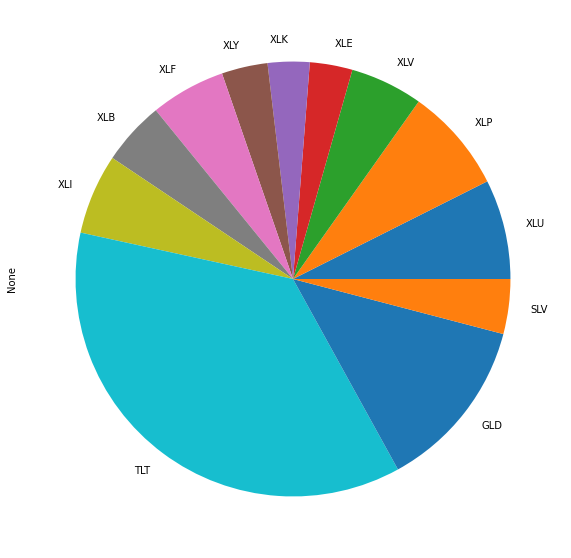

In [16]:
cov_mat = assets_close_prices.cov() # covariance matrix
weights = get_rec_bipart(cov_mat, sort_ix)

new_index = [assets_close_prices.columns[i] for i in weights.index]
weights.index = new_index

print(weights)
plot = weights.plot.pie(y='mass', figsize=(10, 10))